In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy as ap
from astropy import units as u
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord

In [3]:
from itertools import combinations
import os
import datetime
import matplotlib.backends.backend_pdf

Defining Cosmology

In [4]:
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)

In [5]:
kcordir=os.environ["KCORRECT_DIR"]
catbasedir=os.environ["COSMOS_DIR"]

Reading in Catalogs (LAMBDAR and TASCA)

In [6]:
def make_kcorr_filt_template(dataframe):
    '''This task will make a kcorrect filter template from a dataframe that optimizes the number of objects with detections in a subset of filters. In this case the dataframe should contain cfht, subaru, and irac wideband filters. '''
    kcordir=os.environ["KCORRECT_DIR"]
    lambdar_to_kcorr={'cfht_u_mag':'capak_cfht_megaprime_sagem_u.par',
                      'subaru_B_mag':'capak_subaru_suprimecam_B.par',
                      'subaru_V_mag':'capak_subaru_suprimecam_V.par',
                      'subaru_g_mag':'capak_subaru_suprimecam_g.par',
                      'subaru_r_mag':'capak_subaru_suprimecam_r.par',
                      'subaru_i_mag':'capak_subaru_suprimecam_i.par',
                      'subaru_z_mag':'capak_subaru_suprimecam_z.par',
                      'irac_1_mag':'spitzer_irac_ch1.par',
                      'irac_2_mag':'spitzer_irac_ch2.par',
                      'irac_3_mag':'spitzer_irac_ch3.par',
                      'irac_4_mag':'spitzer_irac_ch4.par',
                      'uvista_Y_mag':'vircam_Y.par',
                      'uvista_H_mag':'vircam_H.par',
                      'uvista_J_mag':'vircam_J.par',
                      'uvista_K_mag':'vircam_K.par',}
    numb1=0
    numb2=0
    numb3=0
    numb4=0
    numb5=0
    flist1=[]
    flist2=[]
    flist3=[]
    flist4=[]
    flist5=[]
    ilist1=[]
    ilist2=[]
    ilist3=[]
    ilist4=[]
    ilist5=[]
    kcor_template=kcordir+'/data/templates/temp_filt_list.dat'
    for x in combinations(list(dataframe),5):
        if len(dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)]) > numb1:
            ilist5=ilist4
            ilist4=ilist3
            ilist3=ilist2
            ilist2=ilist1
            ilist1=dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)].index.tolist()
            numb5=numb4
            numb4=numb3
            numb3=numb2
            numb2=numb1
            numb1=len(ilist1)
            flist5=flist4
            flist4=flist3
            flist3=flist2
            flist2=flist1
            flist1=x
    with open(kcor_template,'w') as file:
        file.write('KCORRECT_DIR\n')
        for filt in flist1:
            file.write('data/filters/cosmos_filters/'+lambdar_to_kcorr[filt]+'\n')
    return flist1,kcor_template

In [7]:
print('Reading in Catalogs')
COSMOS_PHOT_LAMBDAR=pd.read_csv(catbasedir+'/Photometry/G10CosmosLAMBDARCatv05.csv')
TASCA_COSMOS_MORPH=pd.read_csv(
    catbasedir+'/Morphology/cosmos_morph_tasca_1.1.tbl',
    delim_whitespace=True,
    header=0,
    dtype=float,
    error_bad_lines=False,
    skiprows=[1,2,3])

Reading in Catalogs


Setting Variables

*********************************************
Matching Catalogs
*********************************************

In [8]:
print('Matching Catalogs')

Matching Catalogs


Generating Astropy skycoord objects to easily match catalogs based on position

In [9]:
TASCA_COSMOS_MORPH.columns

Index(['ID', 'RA', 'DEC', 'ACS_MAG_AUTO', 'Axial_Ratio', 'R_HALF', 'GINI',
       'CONC', 'ASYMMETRY', 'CLASS_INT', 'CLASS_LINEE', 'CLASS_SVM'],
      dtype='object')

In [10]:
TASCA_COORD=SkyCoord(ra=TASCA_COSMOS_MORPH['RA'].values*u.degree,dec=TASCA_COSMOS_MORPH['DEC'].values*u.degree)
G10_COORD=SkyCoord(ra=COSMOS_PHOT_LAMBDAR['RA'].values*u.degree,dec=COSMOS_PHOT_LAMBDAR['DEC'].values*u.degree)

Matching Catalogs

In [11]:
idx,d2d,d3d=G10_COORD.match_to_catalog_sky(TASCA_COORD)
COSMOS_PHOT_LAMBDAR['R_HALF_PIXELS']=TASCA_COSMOS_MORPH['R_HALF'][idx].values
COSMOS_PHOT_LAMBDAR['SEPARATION']=d2d.arcsecond
COSMOS_PHOT_LAMBDAR.loc[COSMOS_PHOT_LAMBDAR.SEPARATION>0.1,'R_HALF_PIXELS']=np.nan
COSMOS_FLUXES=COSMOS_PHOT_LAMBDAR

*********************************************
Calculating apparent magnitudes
*********************************************

In [12]:
print('Calculating apparent magnitudes')

Calculating apparent magnitudes


Determining what data is in each column

In [13]:
column_headers=COSMOS_FLUXES.columns.values
telescope_flux_headers=[s for s in column_headers if (('subaru' in s) or ('uvista' in s) or ('galex' in s) or ('cfht' in s) or ('irac' in s) or ('mips' in s) or ('pacs' in s) or ('spire' in s)) and ('err' not in s)]

In [14]:
zeropoints=[18.82, 20.08, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 30.0, 30.0, 30.0, 30.0, 21.58, 21.58, 21.58, 21.58, 20.15, 17.53, 8.9, 8.9, 8.9, 8.9, 8.9, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4, 31.4]
zeropoint_dict=dict(zip(telescope_flux_headers,zeropoints))

Calculating magnitudes (And creating column for maggies, see kcorrect.org for explanation)

In [15]:
for i in telescope_flux_headers:
    COSMOS_FLUXES[i+'_mag']=-2.5*np.log10(COSMOS_FLUXES[i]/3631.1)
    COSMOS_FLUXES[i+'_mag_err']=2.5/(np.log(10))*COSMOS_FLUXES[i+'_err']/COSMOS_FLUXES[i]

COSMOS_FLUXES.loc[COSMOS_FLUXES.isnull().galex_fuv_mag,'galex_fuv_mag_err']=np.nan
COSMOS_FLUXES.loc[COSMOS_FLUXES.isnull().galex_nuv_mag,'galex_nuv_mag_err']=np.nan

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
optimize_kcorr_filts=COSMOS_FLUXES[[filt for filt in COSMOS_FLUXES.columns.values if ('mag' in filt) & ('maggies' not in filt) & (('subaru' in filt) | ('irac' in filt) | ('cfht' in filt) | ('uvista' in filt)) & ('ia' not in filt) & ('nb' not in filt) & ('err' not in filt)]]

In [17]:
kcorr_filt_list,kcor_template_filter=make_kcorr_filt_template(optimize_kcorr_filts)

In [18]:
maggies_filt_list=[filt.split('_mag')[0]+
                   '_maggies' for filt in kcorr_filt_list]

invervar_filt_list=[filt.split('_mag')[0]+
                    '_invervar' for filt in kcorr_filt_list]

synthetic_maggies_filt_list=[filt.split('_mag')[0]+
                             '_synthetic_maggies' for filt in 
                             kcorr_filt_list]

rf_synthetic_maggies_filt_list=[filt.split('_mag')[0]+
                             '0_synthetic_maggies' for filt in 
                             kcorr_filt_list]

*********************************************
Getting k-correction
*********************************************

Making columns for kcorrect output values

In [19]:
numbers=np.arange(1,7,1)
for string in ['c'+str(number) for number in numbers]:
    COSMOS_FLUXES[string]=np.nan

In [20]:
print('Converting to Maggies')
for column in kcorr_filt_list:
    COSMOS_FLUXES[column.split('_mag')[0]
             +'_maggies']=ut.mag2maggies(COSMOS_FLUXES[column])
    COSMOS_FLUXES[column.split('_mag')[0]
             +'_invervar'
            ]=ut.invariance(COSMOS_FLUXES[column.split('_mag')[0]
                                     +'_maggies'],
                            COSMOS_FLUXES[column
                                     +'_err']
                           )

Converting to Maggies


Making list that contains filters used for k-correction, making columns for synthetic filters. 

Converting to maggies and invervar

Here we make a list of the filters we want to use for the k-correct code

Loading Filters

In [21]:
for i in range(0,len(synthetic_maggies_filt_list)):
    COSMOS_FLUXES[synthetic_maggies_filt_list[i]]=np.nan
    COSMOS_FLUXES[rf_synthetic_maggies_filt_list[i]]=np.nan

In [22]:
kcorrect.load_templates()
kcorrect.load_filters(kcor_template_filter)

In [23]:
indexes=COSMOS_FLUXES.index.values

In [24]:
time=datetime.datetime.now()
for i in indexes:
    COSMOS_FLUXES.loc[i,'c1':'c6']=kcorrect.fit_nonneg(np.array(COSMOS_FLUXES.loc[i,'Z_BEST'],
                                                                dtype=float),
                                                       
                                                       np.array(COSMOS_FLUXES.loc[i,maggies_filt_list],
                                                                dtype=float),
                                                       np.array(COSMOS_FLUXES.loc[i,invervar_filt_list],
                                                                dtype=float))
    COSMOS_FLUXES.loc[i,synthetic_maggies_filt_list]=kcorrect.reconstruct_maggies(COSMOS_FLUXES.loc[i,'c1':'c6'])[1:]
    COSMOS_FLUXES.loc[i,rf_synthetic_maggies_filt_list]=kcorrect.reconstruct_maggies(COSMOS_FLUXES.loc[i,'c1':'c6'],redshift=0)[1:]
    if i%10000==0:
        print('You have gone through {} rows'.format(i))
        print(datetime.datetime.now()-time)
        time=datetime.datetime.now()

You have gone through 0 rows
0:00:00.616395
You have gone through 10000 rows
0:01:53.941199
You have gone through 20000 rows
0:01:52.163214
You have gone through 30000 rows
0:01:50.214535
You have gone through 40000 rows
0:01:49.833583
You have gone through 50000 rows
0:01:49.652957
You have gone through 60000 rows
0:01:51.040473
You have gone through 70000 rows
0:01:50.470371
You have gone through 80000 rows
0:01:50.576496
You have gone through 90000 rows
0:01:49.972158
You have gone through 100000 rows
0:01:50.504040
You have gone through 110000 rows
0:01:50.910121
You have gone through 120000 rows
0:01:52.593177
You have gone through 130000 rows
0:02:28.237872
You have gone through 140000 rows
0:02:11.512240
You have gone through 150000 rows
0:01:50.606889
You have gone through 160000 rows
0:01:52.531990
You have gone through 170000 rows
0:01:48.307431
You have gone through 180000 rows
0:01:41.642457


Recalculating the "maggies" for each object based on the best guess of the SED

In [25]:
COSMOS_FLUXES[[f.split('_mag')[0]+'_synthetic_mag' for f in kcorr_filt_list]]=-2.5*np.log10(COSMOS_FLUXES[synthetic_maggies_filt_list])

Calculating Johnson U/B/V from the SED

In [26]:
COSMOS_FLUXES['UJ0_synthetic_maggies']=np.nan
COSMOS_FLUXES['BJ0_synthetic_maggies']=np.nan
COSMOS_FLUXES['VJ0_synthetic_maggies']=np.nan

In [27]:
kcorrect.load_templates()
kcorrect.load_filters(kcordir+'/data/templates/bessell_ubv.dat')

In [28]:
time=datetime.datetime.now()
for i in indexes:
    COSMOS_FLUXES.loc[i,['UJ0_synthetic_maggies','BJ0_synthetic_maggies','VJ0_synthetic_maggies']]=kcorrect.reconstruct_maggies(COSMOS_FLUXES.loc[i,'c1':'c6'],redshift=0)[1:]
    if i%10000==0:
        print('You have gone through {} rows'.format(i))
        print(datetime.datetime.now()-time)
        time=datetime.datetime.now()

You have gone through 0 rows
0:00:00.663965
You have gone through 10000 rows
0:00:17.369115
You have gone through 20000 rows
0:00:17.607687
You have gone through 30000 rows
0:00:17.320437
You have gone through 40000 rows
0:00:17.276122
You have gone through 50000 rows
0:00:17.582895
You have gone through 60000 rows
0:00:17.521872
You have gone through 70000 rows
0:00:17.153521
You have gone through 80000 rows
0:00:17.107654
You have gone through 90000 rows
0:00:17.226535
You have gone through 100000 rows
0:00:17.273755
You have gone through 110000 rows
0:00:17.413457
You have gone through 120000 rows
0:00:17.481178
You have gone through 130000 rows
0:00:17.363616
You have gone through 140000 rows
0:00:17.117256
You have gone through 150000 rows
0:00:17.229937
You have gone through 160000 rows
0:00:17.456296
You have gone through 170000 rows
0:00:17.266431
You have gone through 180000 rows
0:00:17.140301


Converting to magnitudes and then adding offsets to go from AB magnitudes to Vega magnitudes

In [29]:
COSMOS_FLUXES[[f.split('_mag')[0]+'_kcorr_BJ0' for f in kcorr_filt_list]]=\
-2.5*np.log10(COSMOS_FLUXES[synthetic_maggies_filt_list]/np.stack((COSMOS_FLUXES['BJ0_synthetic_maggies'],
                                                                   COSMOS_FLUXES['BJ0_synthetic_maggies'],
                                                                   COSMOS_FLUXES['BJ0_synthetic_maggies'],
                                                                   COSMOS_FLUXES['BJ0_synthetic_maggies'],
                                                                   COSMOS_FLUXES['BJ0_synthetic_maggies']),axis=-1))

In [30]:
filter_mags=[]
synthetic_filter_mags=[]
for column in list(COSMOS_FLUXES.columns):
    if 'maggies' in column:
        if ('synthetic' in column) & ('0' not in column):
            print(column)
            COSMOS_FLUXES[column.split('_')[0]+'_synthetic_mag']=\
            -2.5*np.log10(COSMOS_FLUXES[column])
            filter_mags.append(column.split('_synthetic')[0]+'_mag')
            synthetic_filter_mags.append(column.split('_synthetic')[0]+'_synthetic_mag')
filter_mags_to_synthetic=dict(zip(filter_mags,synthetic_filter_mags))

subaru_B_synthetic_maggies
subaru_V_synthetic_maggies
subaru_r_synthetic_maggies
subaru_i_synthetic_maggies
subaru_z_synthetic_maggies


In [31]:
COSMOS_FLUXES[['UJ0_synthetic_AB_mag',
               'BJ0_synthetic_AB_mag',
               'VJ0_synthetic_AB_mag']]=-2.5*np.log10(COSMOS_FLUXES[['UJ0_synthetic_maggies',
                                                                    'BJ0_synthetic_maggies',
                                                                    'VJ0_synthetic_maggies']])
COSMOS_FLUXES['UJ0_synthetic_vega_mag']=COSMOS_FLUXES['UJ0_synthetic_AB_mag']-0.79
COSMOS_FLUXES['BJ0_synthetic_vega_mag']=COSMOS_FLUXES['BJ0_synthetic_AB_mag']+0.09
COSMOS_FLUXES['VJ0_synthetic_vega_mag']=COSMOS_FLUXES['VJ0_synthetic_AB_mag']-0.02

In [32]:
COSMOS_FLUXES['rest_frame_B-V']=COSMOS_FLUXES['BJ0_synthetic_vega_mag']-COSMOS_FLUXES['VJ0_synthetic_vega_mag']

In [33]:
COSMOS_FLUXES['BJ0_synthetic_vega_absmag']=COSMOS_FLUXES['BJ0_synthetic_vega_mag']-cosmo.distmod(COSMOS_FLUXES.Z_BEST.values).value

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1922: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1447: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Calculating Absolute Magnitude using k-correction (Different cells below cover different redshift ranges)

subaru_B_mag_err
subaru_B_mag Fit intercept=0.04044038530201749
Apparent Magnitude Median = 22.074185944230365 | Synthetic Magnitude Median = 22.054032975008944
median difference = 0.020152969221420847 | mean difference=0.04044038530201988
 
subaru_V_mag_err
subaru_V_mag Fit intercept=-0.05719624624671011
Apparent Magnitude Median = 21.61954020986866 | Synthetic Magnitude Median = 21.67238776287288
median difference = -0.05284755300422006 | mean difference=-0.0571962462466189
 
subaru_r_mag_err
subaru_r_mag Fit intercept=0.036316004383186655
Apparent Magnitude Median = 21.955608224746697 | Synthetic Magnitude Median = 21.919875052027557
median difference = 0.03573317271914078 | mean difference=0.036316004383060374
 
subaru_i_mag_err
subaru_i_mag Fit intercept=0.013138949437123211
Apparent Magnitude Median = 21.93067313894432 | Synthetic Magnitude Median = 21.919159831045025
median difference = 0.011513307899296166 | mean difference=0.013138949437216496
 
subaru_z_mag_err
subaru_z_mag F

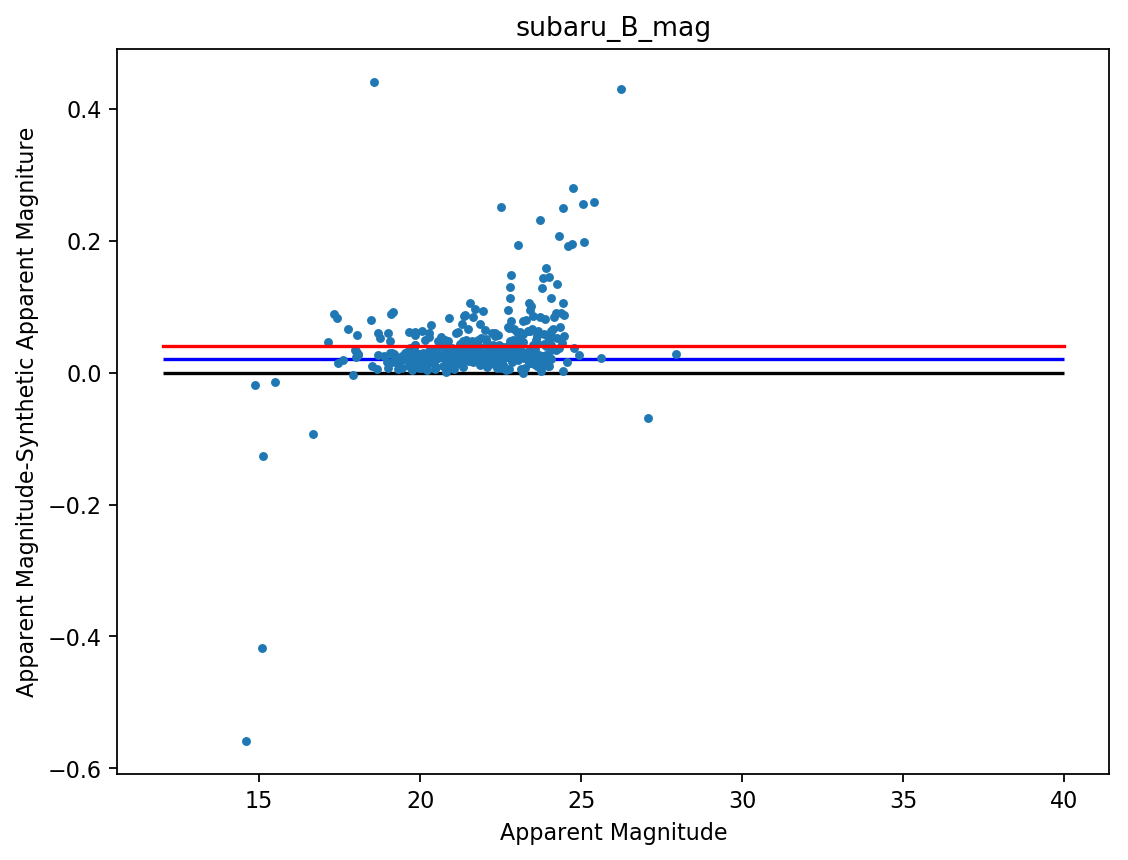

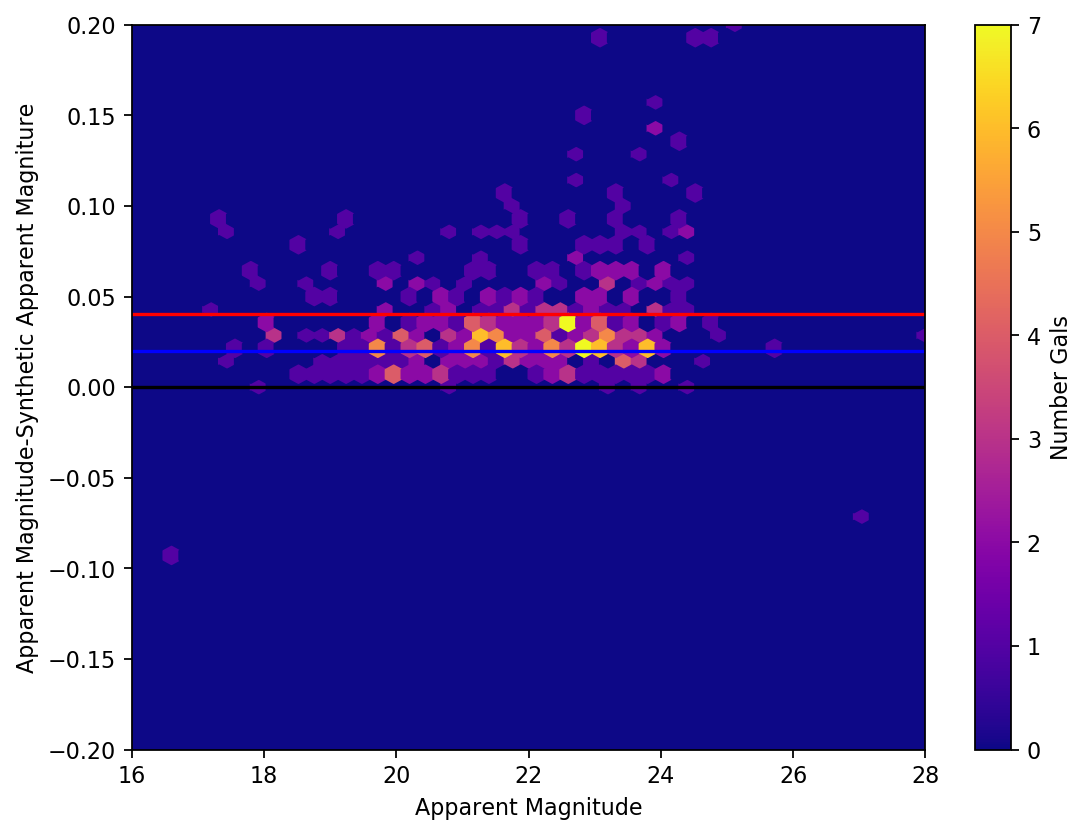

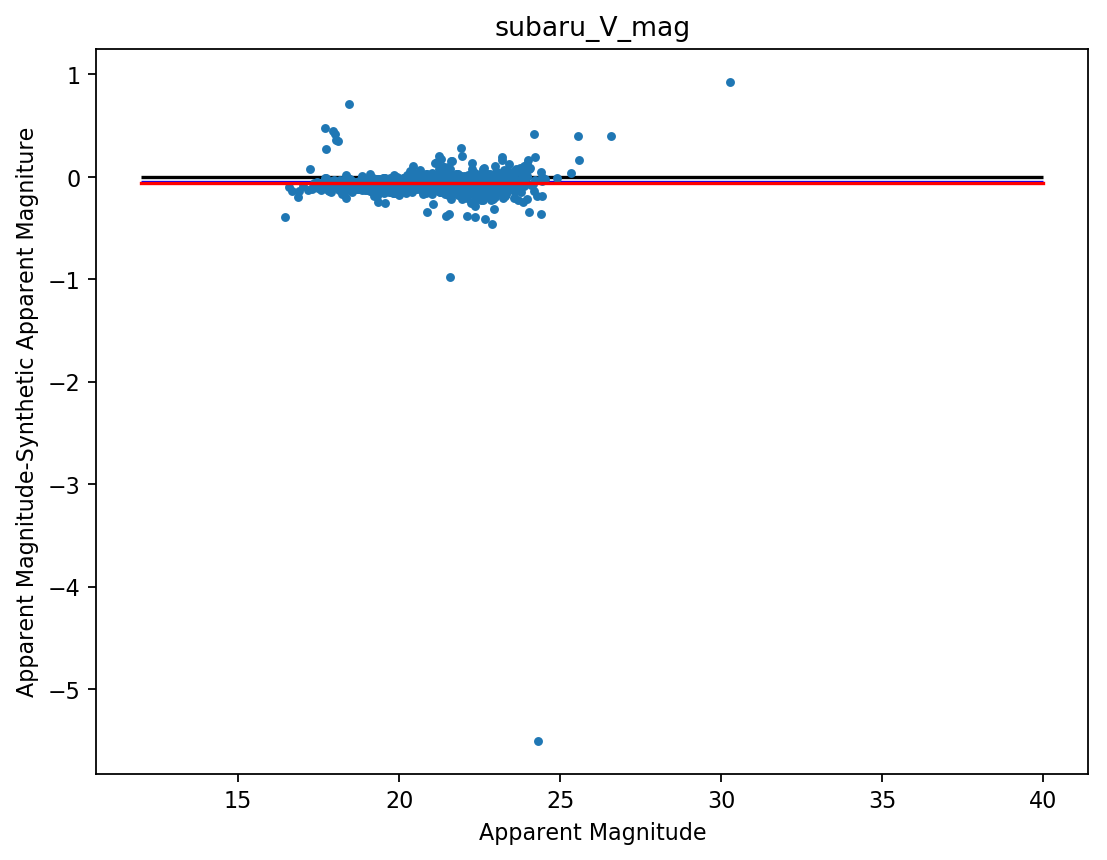

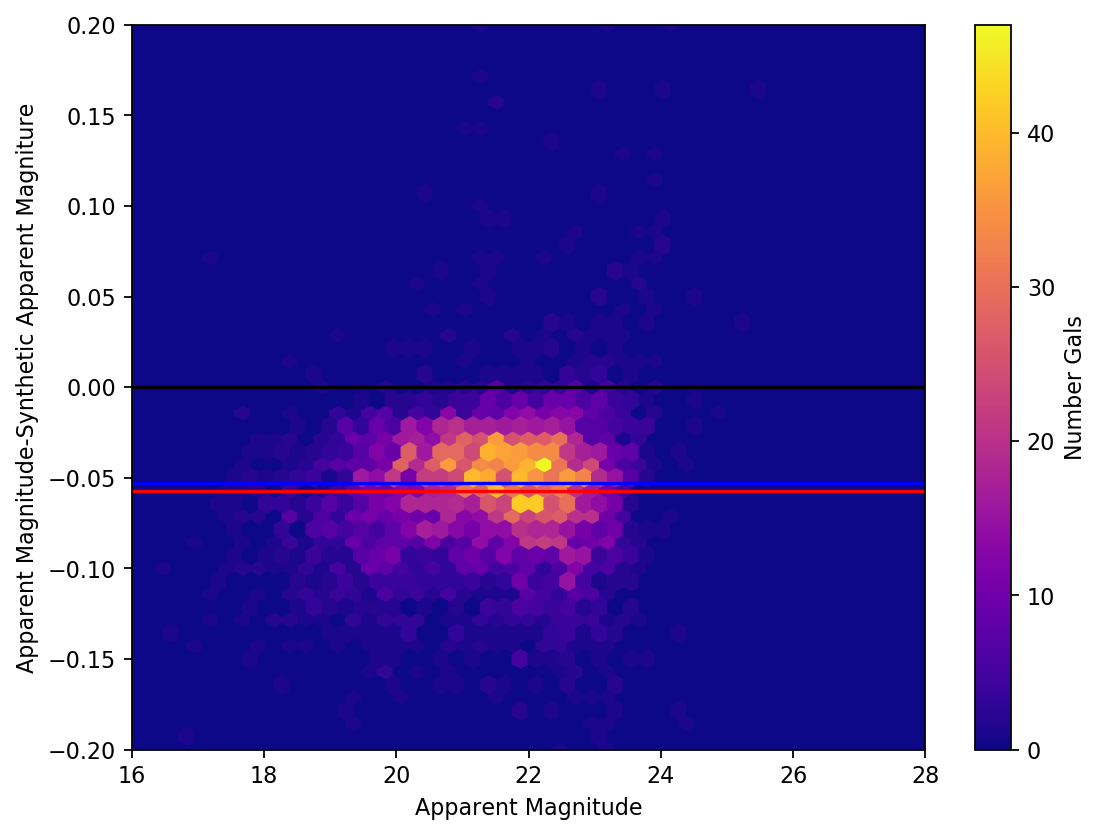

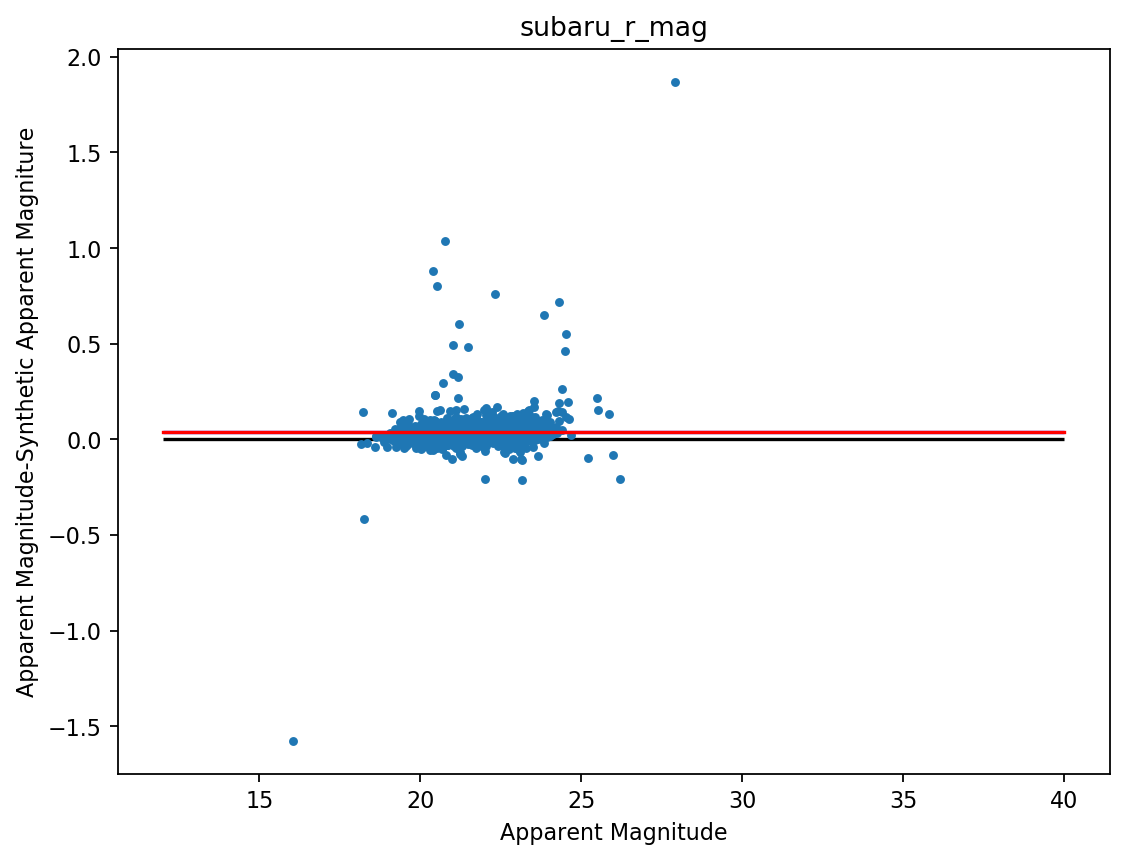

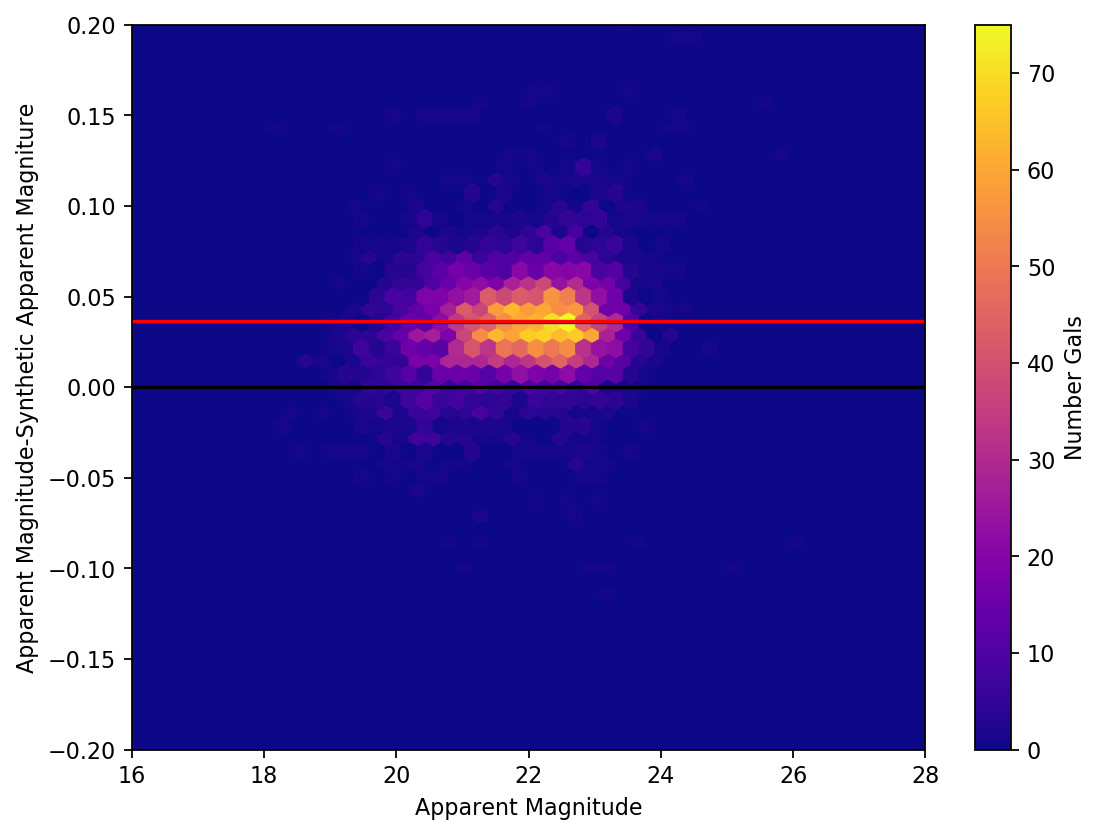

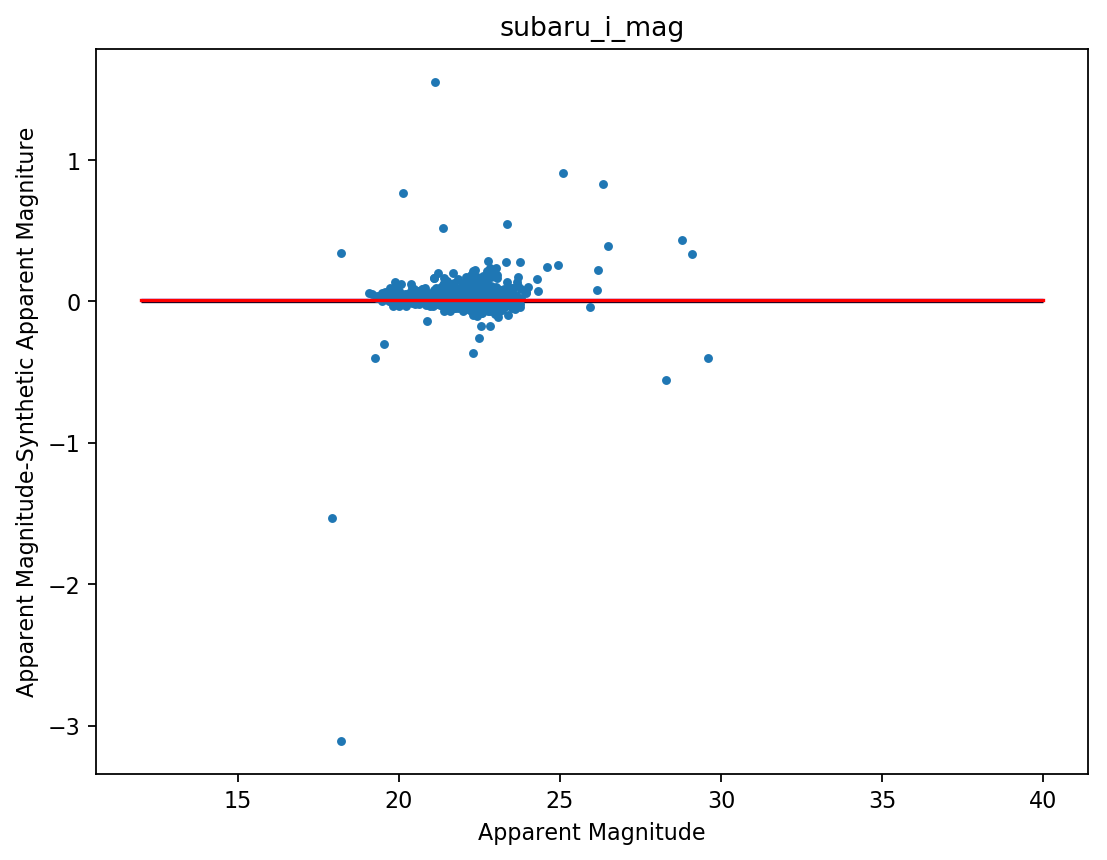

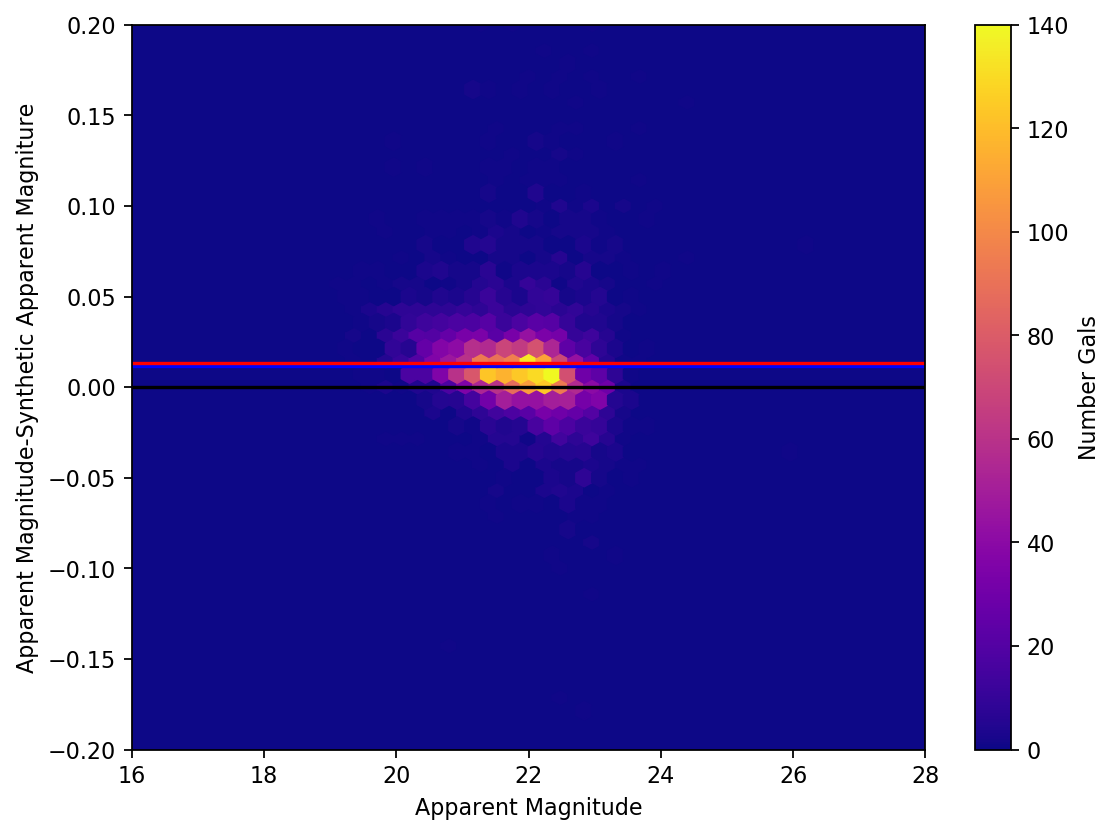

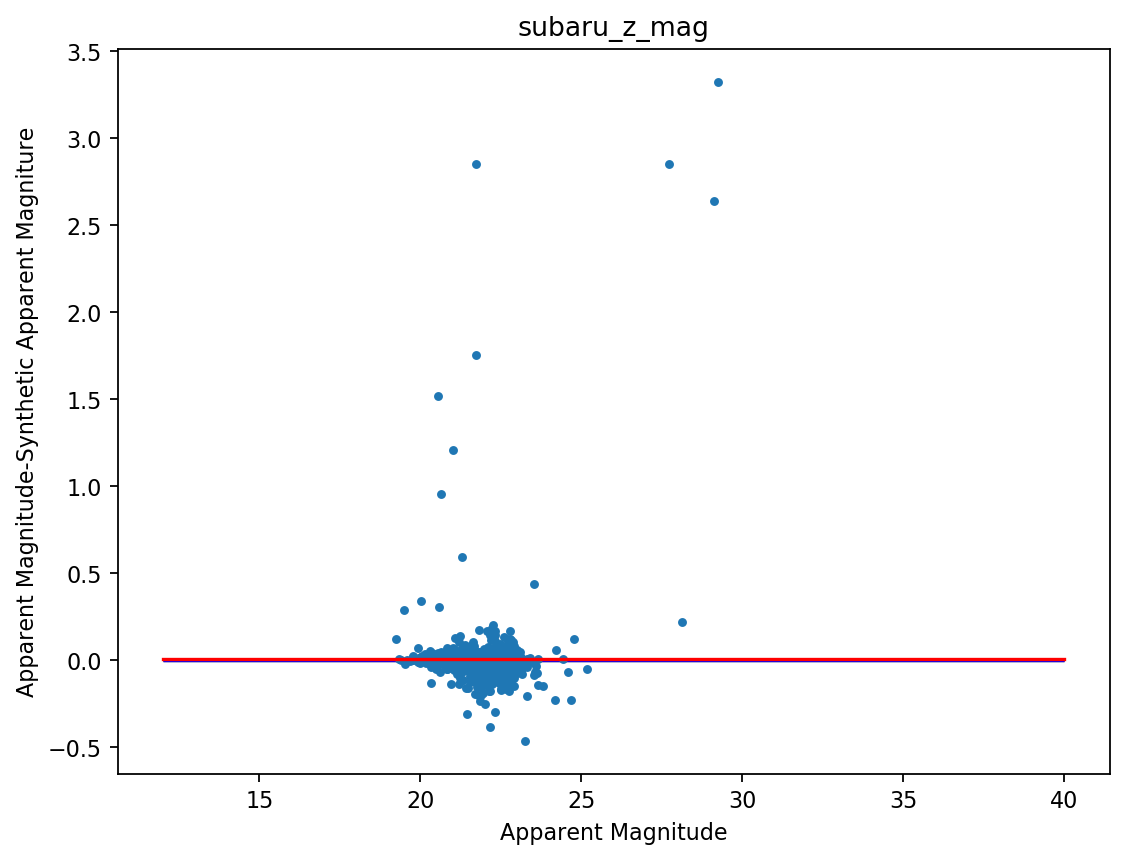

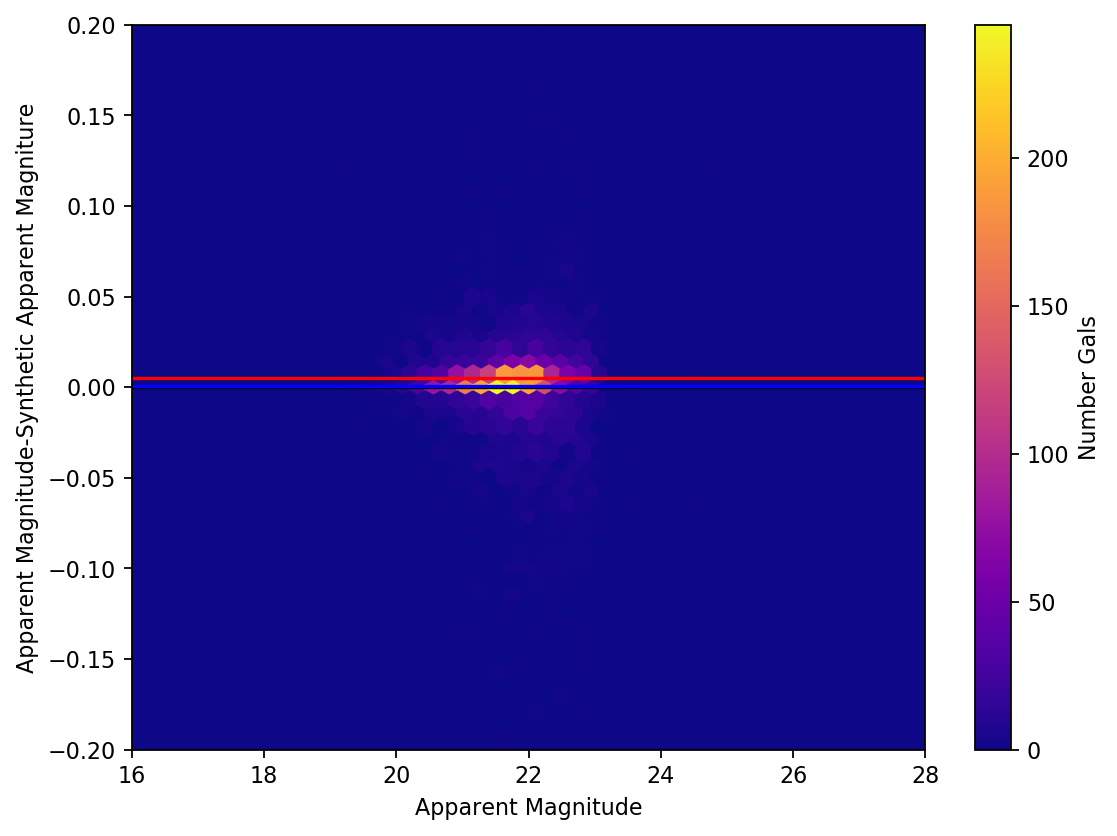

In [34]:
if not os.path.exists('offset_plots'):
    os.mkdir('offset_plots')
z_range_dict_low={'subaru_B_mag':0.0,
                  'subaru_V_mag':0.1,
                  'subaru_r_mag':0.35,
                  'subaru_i_mag':0.55,
                  'subaru_z_mag':0.75}
z_range_dict_high={'subaru_B_mag':0.1,
                   'subaru_V_mag':0.35,
                   'subaru_r_mag':0.55,
                   'subaru_i_mag':0.75,
                   'subaru_z_mag':1.0}
filter_offset_dict={'subaru_B_mag':0.1,
                   'subaru_V_mag':0.35,
                   'subaru_r_mag':0.55,
                   'subaru_i_mag':0.75,
                   'subaru_z_mag':1.0}

for f in filter_mags:
    pdf = matplotlib.backends.backend_pdf.PdfPages('offset_plots/'+f+'synth_vs_meas.pdf')
    p_init=models.Polynomial1D(degree=0)
    fitter=fitting.LinearLSQFitter()
    print(f+'_err')
    p=fitter(p_init,
             COSMOS_FLUXES.loc[
                 (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                 (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                 (COSMOS_FLUXES.Z_USE<3)&
                 (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES[filter_mags_to_synthetic[f]].notnull()),
                 f],
             COSMOS_FLUXES.loc[
                 (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                 (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                 (COSMOS_FLUXES.Z_USE<3)&
                 (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES[filter_mags_to_synthetic[f]].notnull()),
                 f]-COSMOS_FLUXES.loc[
                 (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                 (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                 (COSMOS_FLUXES.Z_USE<3)&
                 (COSMOS_FLUXES.SG_MASTER==0)&
                 (COSMOS_FLUXES[filter_mags_to_synthetic[f]].notnull()),
                 filter_mags_to_synthetic[f]])
    print('{} Fit intercept={}'.format(f,p.c0.value))
    filter_offset_dict[f]=COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                     (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                     (COSMOS_FLUXES.Z_USE<3)&
                     (COSMOS_FLUXES.SG_MASTER==0),
                     f].median()-COSMOS_FLUXES.loc[
            (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
            (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
            (COSMOS_FLUXES.Z_USE<3)&
            (COSMOS_FLUXES.SG_MASTER==0),
            filter_mags_to_synthetic[f]].median()
    fig1=plt.figure(figsize=(8,6),dpi=160)
    plt.plot(COSMOS_FLUXES.loc[
        (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
        (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
        (COSMOS_FLUXES.Z_USE<3)&
        (COSMOS_FLUXES.SG_MASTER==0),
        f],
             COSMOS_FLUXES.loc[
                 (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                 (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                 (COSMOS_FLUXES.Z_USE<3)&
                 (COSMOS_FLUXES.SG_MASTER==0),
                 f]-COSMOS_FLUXES.loc[
                 (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                 (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                 (COSMOS_FLUXES.Z_USE<3)&
                 (COSMOS_FLUXES.SG_MASTER==0),
                 filter_mags_to_synthetic[f]],
             '.')
    plt.xlabel('Apparent Magnitude')
    plt.ylabel('Apparent Magnitude-Synthetic Apparent Magniture')
    plt.hlines(0,12,40)
    plt.plot(np.linspace(12,40,60),p(np.linspace(12,40,60)),color='red')
    plt.hlines(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                     (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                     (COSMOS_FLUXES.Z_USE<3)&
                     (COSMOS_FLUXES.SG_MASTER==0),
                     f].median()-COSMOS_FLUXES.loc[
            (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
            (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
            (COSMOS_FLUXES.Z_USE<3)&
            (COSMOS_FLUXES.SG_MASTER==0),
            filter_mags_to_synthetic[f]].median(),12,40,color='blue')
    plt.title(f)
    #plt.ylim(-0.2,0.2)
    pdf.savefig(fig1)
    fig2,ax=plt.subplots(figsize=(8,6),dpi=160)
    _=ax.hexbin(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                             (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                             (COSMOS_FLUXES.Z_USE<3)&
                             (COSMOS_FLUXES.SG_MASTER==0)&
                             (COSMOS_FLUXES[filter_mags_to_synthetic[f]].notnull()),
                             f],
                COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                             (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                             (COSMOS_FLUXES.Z_USE<3)&
                             (COSMOS_FLUXES.SG_MASTER==0)&
                             (COSMOS_FLUXES[filter_mags_to_synthetic[f]].notnull()),
                             f]-
                COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                             (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                             (COSMOS_FLUXES.Z_USE<3)&
                             (COSMOS_FLUXES.SG_MASTER==0)&
                             (COSMOS_FLUXES[filter_mags_to_synthetic['subaru_B_mag']].notnull()),
                             filter_mags_to_synthetic[f]],
        gridsize=50,
        cmap='plasma',
           extent=[16, 28, -0.2, 0.2])
    ax.hlines(0,16,28)
    ax.hlines(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                     (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                     (COSMOS_FLUXES.Z_USE<3)&
                     (COSMOS_FLUXES.SG_MASTER==0),
                     f].median()-COSMOS_FLUXES.loc[
            (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
            (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
            (COSMOS_FLUXES.Z_USE<3)&
            (COSMOS_FLUXES.SG_MASTER==0),
            filter_mags_to_synthetic[f]].median(),
             16,28,color='blue')
    ax.plot(np.linspace(16,28,60),p(np.linspace(16,28,60)),color='red')
    cb=fig2.colorbar(_,ax=ax)
    cb.set_label('Number Gals')
    ax.set_xlabel('Apparent Magnitude')
    ax.set_ylabel('Apparent Magnitude-Synthetic Apparent Magniture')
    pdf.savefig(fig2)
    print('Apparent Magnitude Median = {} | Synthetic Magnitude Median = {}'.format(
        COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                          (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                          (COSMOS_FLUXES.Z_USE<3)&
                          (COSMOS_FLUXES.SG_MASTER==0),
                     f].median(),
        COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                          (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                          (COSMOS_FLUXES.Z_USE<3)&
                          (COSMOS_FLUXES.SG_MASTER==0),
                     filter_mags_to_synthetic[f]].median(),
        )
         )
    print('median difference = {} | mean difference={}'.format(
        COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                     (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                     (COSMOS_FLUXES.Z_USE<3)&
                     (COSMOS_FLUXES.SG_MASTER==0),
                     f].median()-COSMOS_FLUXES.loc[
            (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
            (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
            (COSMOS_FLUXES.Z_USE<3)&
            (COSMOS_FLUXES.SG_MASTER==0),
            filter_mags_to_synthetic[f]].median(),
        COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
                     (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
                     (COSMOS_FLUXES.Z_USE<3)&
                     (COSMOS_FLUXES.SG_MASTER==0),
                     f].mean()-COSMOS_FLUXES.loc[
            (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
            (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f])&
            (COSMOS_FLUXES.Z_USE<3)&
            (COSMOS_FLUXES.SG_MASTER==0),
            filter_mags_to_synthetic[f]].mean()
    )
         )
    print(' ')
    pdf.close()


In [35]:
COSMOS_FLUXES['BJ0_vega_absmag']=np.nan
for f in filter_mags:
    COSMOS_FLUXES.loc[
        (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
        (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f]),
        'BJ0_vega_absmag']=COSMOS_FLUXES.loc[
        (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
        (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f]),
        f]-filter_offset_dict[f]-cosmo.distmod(COSMOS_FLUXES.loc[
        (COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
        (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f]),
        'Z_BEST']).value-COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>z_range_dict_low[f])&
        (COSMOS_FLUXES.Z_BEST<z_range_dict_high[f]),
        f.split('_mag')[0]+'_kcorr_BJ0']+0.09
    print(f)
COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST>1,
             'BJ0_vega_absmag']=COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST>1,
                                             'subaru_z_mag']-filter_offset_dict['subaru_z_mag']-cosmo.distmod(
COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST>1,
              'Z_BEST']).value-COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST>1,
                                             'subaru_z_kcorr_BJ0']+0.09

subaru_B_mag
subaru_V_mag
subaru_r_mag
subaru_i_mag
subaru_z_mag


# Ignore below for now. Can add back later

Below we need to calculate surface brightness. Do this using the absolute magnitude. 

SB=$M_{B}+2.5\times~log_{10}(2\pi~R_{e}^{2})+36.572$

effective radius as a function of wavelength


$log_{10}(R_{e})=-0.108\times~log_{10}(\lambda)+0.887$


When comparing the radius at two wavelengths 


$log_{10}(R_{e,\lambda_{1}})-log_{10}(R_{e,\lambda_{2}})=-0.108\times~log_{10}(\lambda_{1})+0.108\times~log_{10}(\lambda_{2})+0.887-0.887$

which can be reduced to

$log_{10}(\frac{R_{e,\lambda_{1}}}{R_{e,\lambda_{2}}})=-0.108\times~log_{10}(\frac{\lambda_{1}}{\lambda_{2}})$

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{B}}{\lambda_{J}}^{-0.108}$

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{J}}{\lambda_{B}}^{0.108}$

Need to account for fact that radius is observed J. To get to emitted wavelength need to divide $\lambda_{J}$ by (1+z)

$\frac{R_{e,B}}{R_{e,J}}=\frac{\lambda_{J}}{\lambda_{B}}^{0.108}\times(1+z)^{-0.108}$

$\lambda_{J}=1.25e^{-6}~~ \lambda_{B}=0.445e^{-6}$

$R_{e,B} = 1.12 \times (1+z)^{-0.108} \times R_{e,J}$

COSMOS_FLUXES['BJ0_vega_surface_brightness']=\
(COSMOS_FLUXES['BJ0_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(COSMOS_FLUXES.Z_BEST.values).value*
              (
                  (
                      1.07*
                      (1+COSMOS_FLUXES.Z_BEST)**(-0.108)
                  )*
                  (
                      COSMOS_FLUXES.R_HALF_PIXELS.values*
                      0.03
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

In [ ]:
COSMOS_FLUXES['BJ0_vega_surface_brightness']=\
(COSMOS_FLUXES['BJ0_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(COSMOS_FLUXES.Z_BEST.values).value*
              (
                  (
                      COSMOS_FLUXES.R_HALF_PIXELS.values*
                      0.03
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

In [37]:
COSMOS_FLUXES['R_HALF_ARCSEC_F814W']=COSMOS_FLUXES.loc[:,'R_HALF_PIXELS']*0.03
COSMOS_FLUXES['R_HALF_ARCSEC_B']=COSMOS_FLUXES.loc[:,'R_HALF_PIXELS']*0.03*(814/(445*(1+COSMOS_FLUXES.Z_BEST.values)))**0.108
COSMOS_FLUXES['is_LCBG']=0
COSMOS_FLUXES.loc[(COSMOS_FLUXES.BJ0_vega_absmag.values<-18.5)&(COSMOS_FLUXES.BJ0_vega_surface_brightness.values<21)&(COSMOS_FLUXES['rest_frame_B-V'].values<0.6),'is_LCBG']=1

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [39]:
COSMOS_FLUXES.to_csv(catbasedir+'/Final_Catalogs/COSMOS_CONVERTED_CATALOG.csv')

In [ ]:
len(COSMOS_FLUXES.loc[(COSMOS_FLUXES.is_LCBG==1)&(COSMOS_FLUXES.Z_USE<3)])

Calculate absolute magnitude from the "Synthetic" apparent magnitude

Diagnostic plotting

In [ ]:
plt.plot(COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST<1.0,'BJ0_vega_absmag'],
         COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST<1.0,'BJ0_vega_absmag']-COSMOS_FLUXES.loc[COSMOS_FLUXES.Z_BEST<1.0,'BJ0_synthetic_vega_absmag'],'.')
plt.plot(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&(COSMOS_FLUXES.Z_USE<2)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag'],
         COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                           (COSMOS_FLUXES.Z_USE<2)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag']-COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                                                          (COSMOS_FLUXES.Z_USE<2)&
                                                          (COSMOS_FLUXES.SG_MASTER==0),
                                                          'BJ0_synthetic_vega_absmag'],'.')
print(len(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST>0.01)&(COSMOS_FLUXES.Z_BEST<1.0)&(COSMOS_FLUXES.Z_USE<2)&(COSMOS_FLUXES.SG_MASTER==0),'BJ0_vega_absmag']))
plt.hlines(0.25,-30,200)
plt.hlines(-0.25,-30,200)
plt.hlines(0,-30,200)
plt.ylim(-1,1)
plt.xlim(-28,-15)

In [ ]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&(COSMOS_FLUXES.Z_USE<3)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag'],
         COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                           (COSMOS_FLUXES.Z_USE<3)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag']-COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                                                          (COSMOS_FLUXES.Z_USE<3)&
                                                          (COSMOS_FLUXES.SG_MASTER==0),
                                                          'BJ0_synthetic_vega_absmag']
           ,gridsize=75,cmap='plasma',extent=[-26,-16,-0.3,.3])
plt.hlines(0,-26,-16)

In [ ]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag'],
         COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                           (COSMOS_FLUXES.SG_MASTER==0),
                           'BJ0_vega_absmag']-COSMOS_FLUXES.loc[(COSMOS_FLUXES.Z_BEST<1.0)&
                                                          (COSMOS_FLUXES.SG_MASTER==0),
                                                          'BJ0_synthetic_vega_absmag']
           ,gridsize=75,cmap='plasma',extent=[-26,-16,-0.3,.3])
plt.hlines(0,-26,-16)

Calculate surface brightness

Calculate effective radius and determine whether each source is an LCBG

In [ ]:
plt.plot(COSMOS_FLUXES['rest_frame_B-V'],COSMOS_FLUXES['Surface_Brightness_B'],'.')